## Building a router agent to classify text/reviews and draft up a response

In [ ]:
# built-in libraries
import os
from typing import Literal, TypedDict,  Any, Optional, Tuple, List, Dict, Union

# langgraph libraries
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import  MermaidDrawMethod

# misc libraries
from pydantic import Field
from IPython.display import Image
import pandas as pd
import numpy as np
#from decouple import config
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from tqdm import tqdm
from sklearn.metrics import f1_score




In [33]:
from datasets import load_dataset
from typing import List, Dict
from nltk.tokenize import sent_tokenize
from collections import defaultdict

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Valdemar
[nltk_data]     Schultz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_score, recall_score

Watsonx credentials

In [ ]:
WX_API_KEY = os.getenv("WX_API_KEY")
WX_PROJECT_ID_RAG = os.getenv("WX_PROJECT_ID_RAG")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"



Getting our LLM caller class - Defined in LLM.py

In [ ]:

model = LLMCaller(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID_RAG,
    api_url=WX_API_URL,
    model_id="watsonx/ibm/granite-3-8b-instruct",
    params={
        GenParams.TEMPERATURE: 0.3,
        GenParams.MAX_NEW_TOKENS: 70,
    }
)

### Creating our few shot examples data set for the LLM to learn from
We will use the few shot examples to train the LLM to classify the text and draft a response

In [24]:
# 1) Load your CSV
csv_path = os.path.join("data", "ekman_train.csv")
# Expect columns: text, ekman_emotion
df = pd.read_csv(csv_path)


creating few shot dataframe

In [ ]:
# Define the order of emotion columns. idxmax will pick the first one if multiple emotions are present.
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Find the emotion for each row.
# This creates a new series where each value is the column name of the first '1' found in emotion_columns.
df['ekman_emotion'] = df[emotion_columns].idxmax(axis=1)

# Recreate the DataFrame with only the 'text' and 'ekman_emotion' columns.
# This overwrites the original df, which is expected by the subsequent cells.
df = df[['text', 'ekman_emotion']]

# You can print the head of the modified DataFrame to verify
print("Transformed DataFrame head:")
print(df.head())

Createing my embedding tool

In [38]:
# 2. Load a local embedding model
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

# 3. Helper to embed one or more texts
def embed(texts):
    """
    texts: a single string or list of strings
    returns: numpy array of shape (n_texts, 384)
    """
    # If a single string, wrap it in a list for the model call
    single = False
    if isinstance(texts, str):
        texts = [texts]
        single = True

    embs = embed_model.encode(texts, convert_to_numpy=True)

    # If only one input, return its vector directly
    return embs[0] if single else embs


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Chunking the few-shot examples

In [ ]:

# 2) Chunk long texts into 1–2 sentence chunks (if you want)
def chunk_text(text, max_sentences=2):
    sents = sent_tokenize(text)
    for i in range(0, len(sents), max_sentences):
        yield " ".join(sents[i : i + max_sentences]).strip()

shots = []
for _, row in df.iterrows():
    text = row["text"].strip()
    emo  = row["ekman_emotion"]
    for chunk in chunk_text(text):
        shots.append({"text": chunk, "emotion": emo})

# 4) Balance to N examples per emotion (to avoid over-representing any one)
N = 200
by_emo = defaultdict(list)
for shot in shots:
    by_emo[shot["emotion"]].append(shot)

few_shots = []
for emo, lst in by_emo.items():
    few_shots.extend(lst[:N])

print(f"Prepared {len(few_shots)} few-shot examples "
      f"({len(by_emo)} emotions × up to {N} each)")

Prepared 1400 few-shot examples (7 emotions × up to 200 each)


Embedding the few-shot examples

In [ ]:
# 1) Embed each shot in place
for shot in few_shots:
    shot["embedding"] = embed(shot["text"])

# 2) (Optional) Build an (N, D) matrix for retrieval
emb_matrix = np.vstack([shot["embedding"] for shot in few_shots]).astype("float32")

print(f"Embedded {len(few_shots)} few-shot examples into a {emb_matrix.shape} array")


Embedded 1400 few-shot examples into a (1400, 384) array


In [ ]:
# Define your state type
class ReviewState(TypedDict):
    review_text: str
    few_shot_examples: List[Dict[str, str]] 
    emotion: [str]
    draft_reply: [str]
    verbose: bool = False

Creating the nodes of the system

In [42]:
few_shots: List[Dict[str, object]] = few_shots # List of few-shot examples
emb_matrix: np.ndarray = np.vstack([shot["embedding"] for shot in few_shots]).astype("float32")

In [44]:
def read_review(state: ReviewState) -> dict:
    """Reviewbot loads and logs the incoming customer review"""
    review = state["review_text"]
    if state["verbose"]:
        print(f"Reviewbot received review: “{review}”")
    # no changes to state here
    return {}


#dynamic few-shotting technique, matches unseen reviews to the most similar few-shot examples
def retrieve_few_shot_examples(state: ReviewState) -> dict:
    """
    Embed the incoming review, compute cosine similarity against your pre-embedded few_shots,
    and stash the top-5 (text, emotion) pairs into state['few_shot_examples'].
    """
    # 1) Embed the new review
    q_emb = embed(state["review_text"]).reshape(1, -1).astype("float32")
    
    # 2) Compute cosine similarities
    sims = cosine_similarity(q_emb, emb_matrix)[0]  # shape (N,)
    
    # 3) Grab top-5 indices
    topk = sims.argsort()[-5:][::-1]
    
    # 4) Build a simple list of {text, emotion}
    state["few_shot_examples"] = [
        {"text": few_shots[i]["text"], "emotion": few_shots[i]["emotion"]}
        for i in topk
    ]
    return {}  # no state keys beyond few_shot_examples

def classify_emotion(state: ReviewState) -> dict:
    """Use the LLM with few-shot context + Ekman definitions to pick emotions."""
    text = state["review_text"]
    # Format few-shot context
    example_lines = "\n".join(
        f"- “{ex['text']}” → {ex['emotion']}"
        for ex in state["few_shot_examples"]
    )
    
    prompt = f"""
You are an expert at mapping customer reviews to Ekman’s six emotions (or neutral).

Here are a few similar, labeled examples:
{example_lines}

Now classify this new review into one or more of:
anger, disgust, fear, joy, sadness, surprise, neutral.

Review:
\"\"\"{text}\"\"\"

Respond **only** in JSON with:
  • emotion: a string or list of strings from the set above.
"""
    response_model = model.create_response_model(
        "FewShotEmotionClassification",
        {
            "emotion": (
                # allow multi-label if you want, or just one
                List[Literal["anger","disgust","fear","joy","sadness","surprise","neutral"]],
                Field(description="The chosen Ekman emotion(s)")
            ),
        }
    )
    resp = model.invoke(prompt, response_model=response_model)
    
    return {"emotion": resp.emotion}

def draft_response(state: ReviewState) -> dict:
    """Draft an empathetic reply based on the classified emotion"""
    text = state["review_text"]
    emo  = state["emotion"] or "neutral"
    prompt = f"""A customer expresses **{emo}** in this review:
\"\"\"{text}\"\"\"

Write a concise, empathetic customer-service response that:
  - Acknowledges their {emo},
  - Addresses any concerns they raise,
  - Invites further dialogue if needed.
"""
    resp = model.invoke(prompt)
    return {"draft_reply": resp.answer}


def notify_user(state: ReviewState) -> dict:
    """Present the final draft back to the support employee"""
    if state["verbose"]:
        print("\n" + "="*40)
        print(f"Review classified as: {state['emotion']}")
        print("Draft response:")
        print(state["draft_reply"])
        print("="*40 + "\n")
    return {}

No need for conditional edge as it is a linear system

### Creating Graph of the system

In [47]:
# Create the graph
review_graph = StateGraph(ReviewState)  # Initialize with your ReviewState

# Add nodes
review_graph.add_node("read review",       read_review)
review_graph.add_node("retrieve few-shot examples", retrieve_few_shot_examples)
review_graph.add_node("classify emotion",  classify_emotion)
review_graph.add_node("draft response",    draft_response)
review_graph.add_node("notify user",      notify_user)

# Wire up the edges
# 1) START → read_review
review_graph.add_edge(START, "read review")

review_graph.add_edge("read review", "retrieve few-shot examples")
# 2) retrieve_few_shot_examples → classify_emotion
review_graph.add_edge("retrieve few-shot examples", "classify emotion")

# 3) classify_emotion → route_review
review_graph.add_edge("classify emotion", "draft response")

#4 ) draft_response → notify_user
review_graph.add_edge("draft response", "notify user")

# 5) notify_user → END
review_graph.add_edge("notify user", END)


compiled_graph = review_graph.compile()

Print the graph

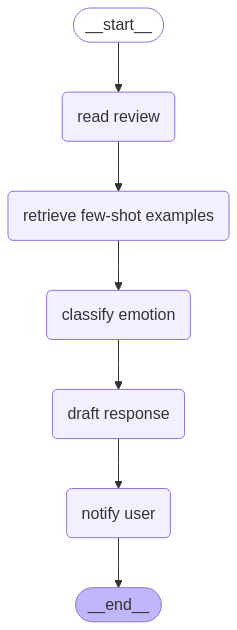

In [48]:
Image(compiled_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))